In [69]:

import openmc
import matplotlib.pyplot as plt
import openmc_source_plotter
import numpy as np
import neutronics_material_maker as nmm

In [187]:
#import real measurement data

res_path = "results_bi_cf.txt"

with open(res_path) as myfile:
  data = myfile.readlines()

data = data[5:]

erg = []
meas_value = []
meas_uncert = []

for line in data:
    line = line.strip()
    line =  " ".join(line.split())
    line = line.split()
    erg.append(float(line[0]))
    meas_value.append(float(line[1]))
    meas_uncert.append(float(line[4]))

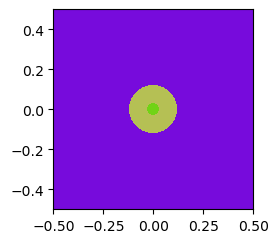

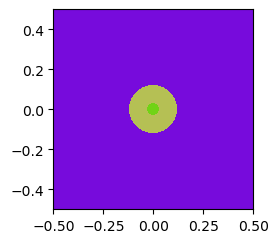

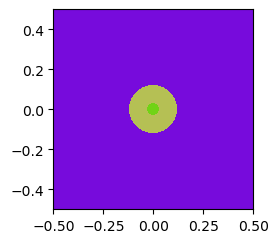

In [115]:
Bi = openmc.Material(name='Bi209')
Bi.add_nuclide('Bi209',1)

mats = openmc.Materials([Bi])

outer_shell = openmc.Sphere(r=0.12)
inner_shell = openmc.Sphere(r=0.03)

detector_outer_surface = openmc.Sphere(r=6.8, boundary_type='vacuum')
detector_surface = openmc.Sphere(r=6.79)

bi_shell = -outer_shell &  +inner_shell
shell_cell = openmc.Cell(region=bi_shell)
shell_cell.fill = Bi

detector_cell = openmc.Cell(region=-detector_surface & +outer_shell)
outer = openmc.Cell(region=-detector_outer_surface & +detector_surface)
inner_cell = openmc.Cell(region=-inner_shell)

universe = openmc.Universe(cells=[shell_cell, detector_cell, inner_cell, outer])

x,y = 1,1

plt.show(universe.plot(width=(x, y), basis='xz'))
plt.show(universe.plot(width=(x, y), basis='xy'))
plt.show(universe.plot(width=(x, y), basis='yz'))

geom = openmc.Geometry(universe)

In [116]:
#settings
sett = openmc.Settings()
sett.batches = 5
sett.inactive = 0
sett.particles = 100000
sett.run_mode = 'fixed source'


In [117]:
#create the neutron source 
source = openmc.Source()
source.space = openmc.stats.Point((0,0,0))
source.angle = openmc.stats.Isotropic() 
#cf-252 energy distribution (spontaneous fission) taken from: https://journals.aps.org/pr/pdf/10.1103/PhysRev.108.411
source.energy = openmc.stats.Watt(a=1.209e6, b=(1/(0.836e6)))
source.particle = 'neutron'
sett.source = source

In [188]:
#tally
tallies = openmc.Tallies()
energy_bins = np.array(erg)
energy_filter = openmc.EnergyFilter(energy_bins)

neutron_particle_filter = openmc.ParticleFilter(['neutron'])

surface_filter = openmc.SurfaceFilter(detector_surface)

detector_surface_tally = openmc.Tally(name='detector_surface_tally')
detector_surface_tally.scores = ['current']
detector_surface_tally.filters = [energy_filter, neutron_particle_filter, surface_filter]
tallies.append(detector_surface_tally)

shell_surface_filter = openmc.SurfaceFilter(outer_shell)
outer_bi_tally = openmc.Tally(name='outer_bi_tally')
outer_bi_tally.scores = ['current']
outer_bi_tally.filters = [energy_filter, neutron_particle_filter, shell_surface_filter]
tallies.append(outer_bi_tally)

In [189]:
# combine all the required parts to make a model
model = openmc.model.Model(geom, mats, sett, tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [193]:
# open the results file
import pandas as pd
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
cell_tally = results.get_tally(name='detector_surface_tally')
print(cell_tally.

[6.927e-08 8.947e-08 1.096e-07 1.297e-07 1.497e-07 1.698e-07 1.898e-07
 2.096e-07 2.434e-07 2.935e-07 3.439e-07 3.942e-07 4.443e-07 4.946e-07
 5.679e-07 6.676e-07 7.682e-07 8.700e-07 9.693e-07 1.114e-06 1.313e-06
 1.512e-06 1.718e-06 1.925e-06 2.124e-06 2.321e-06 2.522e-06 2.722e-06
 2.915e-06 3.202e-06 3.617e-06 4.013e-06 4.392e-06 4.794e-06 5.295e-06
 5.920e-06 6.502e-06 7.059e-06 7.690e-06 8.332e-06 8.889e-06 9.507e-06
 1.019e-05 1.083e-05 1.155e-05 1.233e-05 1.319e-05]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


ValueError: x and y must have same first dimension, but have shapes (47,) and (46,)

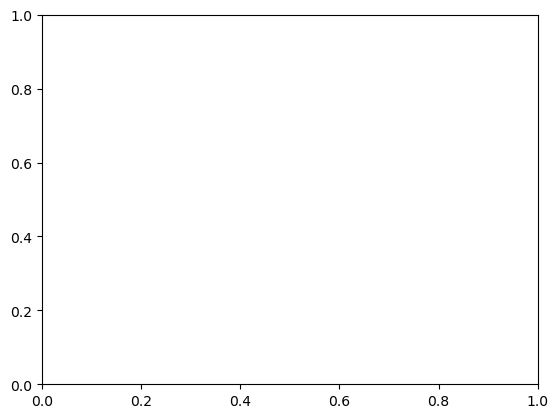

In [192]:
flux = cell_tally.mean.ravel()
flux_unc = cell_tally.std_dev.ravel()
energy = np.array(erg)
energy = energy/10e5
flux = flux *10
print(energy)
print(flux)

plt.step(energy, flux)


plt.step(erg, meas_value)
plt.xlabel("Energy (MeV)")
plt.ylabel("Intensity (n/MeV)")
plt.show()